In [1]:
from calibration_tools import * 
from forward_variance import *

**Step 1 (Replication formula).** Recall that $$\boxed{\frac{1}{T}\int_0^T \xi_0(t)\, dt = \frac{2}{T}\left(\int_{-\infty}^{F(T)} \frac{P(T, K)}{K^2}\, dK + \int_{F(T)}^{+\infty} \frac{C(T,K)}{K^2}\, dK\right)}$$




Let's define the forward log-moneyness $k := \ln(K/F)$. Given the implied volatility $\sigma_{\mathrm{imp}}(T,k)$, define the total volatility
$\Sigma(T,k):=\sigma_{\mathrm{imp}}(T,k)\sqrt{T}.$

Note that \begin{align*}
W(T) := \int_0^T \xi_0(t)\, dt &= 2\left(\int_{-\infty}^{F(T)} \frac{P(T, K)}{K^2}\, dK + \int_{F(T)}^{+\infty} \frac{C(T,K)}{K^2}\, dK\right)\\
&= 2\left(\int_{-\infty}^0 \dfrac{P(T,K)}{F(T)e^k}dk + \int_0^{+\infty} \dfrac{C(T,K)}{F(T)e^k}dk\right)\\
&= 2\left(\int_{-\infty}^0 e^{-k}\left(e^{k}\Phi(-d_2) - \Phi(-d_1)\right)\,dk + \int_0^{+\infty} e^{-k}\left(\Phi(d_1) - e^{k}\Phi(d_2)\right)\, dk\right) = 2\int_{-\infty}^{+\infty} \Phi\left(d_2\right)\, dk
\end{align*}
with $\Phi()$ the cdf of $\mathcal N(0,1)$, $d_1(T,k) = -\dfrac{k}{\Sigma(T,k)} + \dfrac{\Sigma(T,k)}{2}$ and $d_2(T,k) = d_1(T,k) - \Sigma(T,k)$.

Now, let's define $y(T,k) := \Phi(d_2(T,k))$, such that $W(T) = 2\displaystyle \int_{-\infty}^{+\infty} y(T,k)\, dk$. It is clear that $y\longmapsto y(T,k)$ is decreasing and continuous such that \begin{align*}
\lim_{k\longrightarrow-\infty} y(k) &= 1,\\
\lim_{k\longrightarrow+\infty} y(k) &= 0.\\
\end{align*}
A simple change of variable ($dk/dy = -\Sigma(T,y)^2/2$) leads to $W(T) = \displaystyle\int_0^T \Sigma(T, y)^2\, dy$.

**Step 2 (Smoothing).** While defining $w(T) = W(T)/T$, we obtain $w(T_i) = W(T_i)/T_i$, for a discret set of maturities $T_i$, $i=1,\ldots, n$. Since the market estimates $w(T_i)$ are noisy, we first construct a smooth curve $T\longmapsto W(T)$ and then define $\xi_0(T) = W'(T)$ (our quantity of interest).

We model $W$ as a linear combination of kernel functions:
$$W(T) = \sum_{i=1}^n Z_i K(T,T_i), \qquad K(T,T_i) := 1-\frac{\min(T,T_i)^3}{6}+\frac{TT_i}{2}\left(2+\min(T,T_i)\right).$$

Let $A$ be the (Gram) matrix $A_{ij} = K(T_i, T_j)$. Enforcing interpolation at the nodes $W(T_i) = W_i$ yields the linear system $AZ = W$, hence $Z = A^{-1}W$, and the forward varaince curve is then obtained by differentiating the above expansion:
$$\xi_0(T) = \sum_{i=1}^n Z_i \partial_T K(T,T_i), \qquad \partial_T K(T, T_i) = T - \frac{\min(T,T_i)^2}{2} + T \min(T,T_i).$$

In [10]:
df = pd.read_csv('spx_options_2017_05_19.csv', sep=',')
SPX = prepare_raw_data_SPX(df)

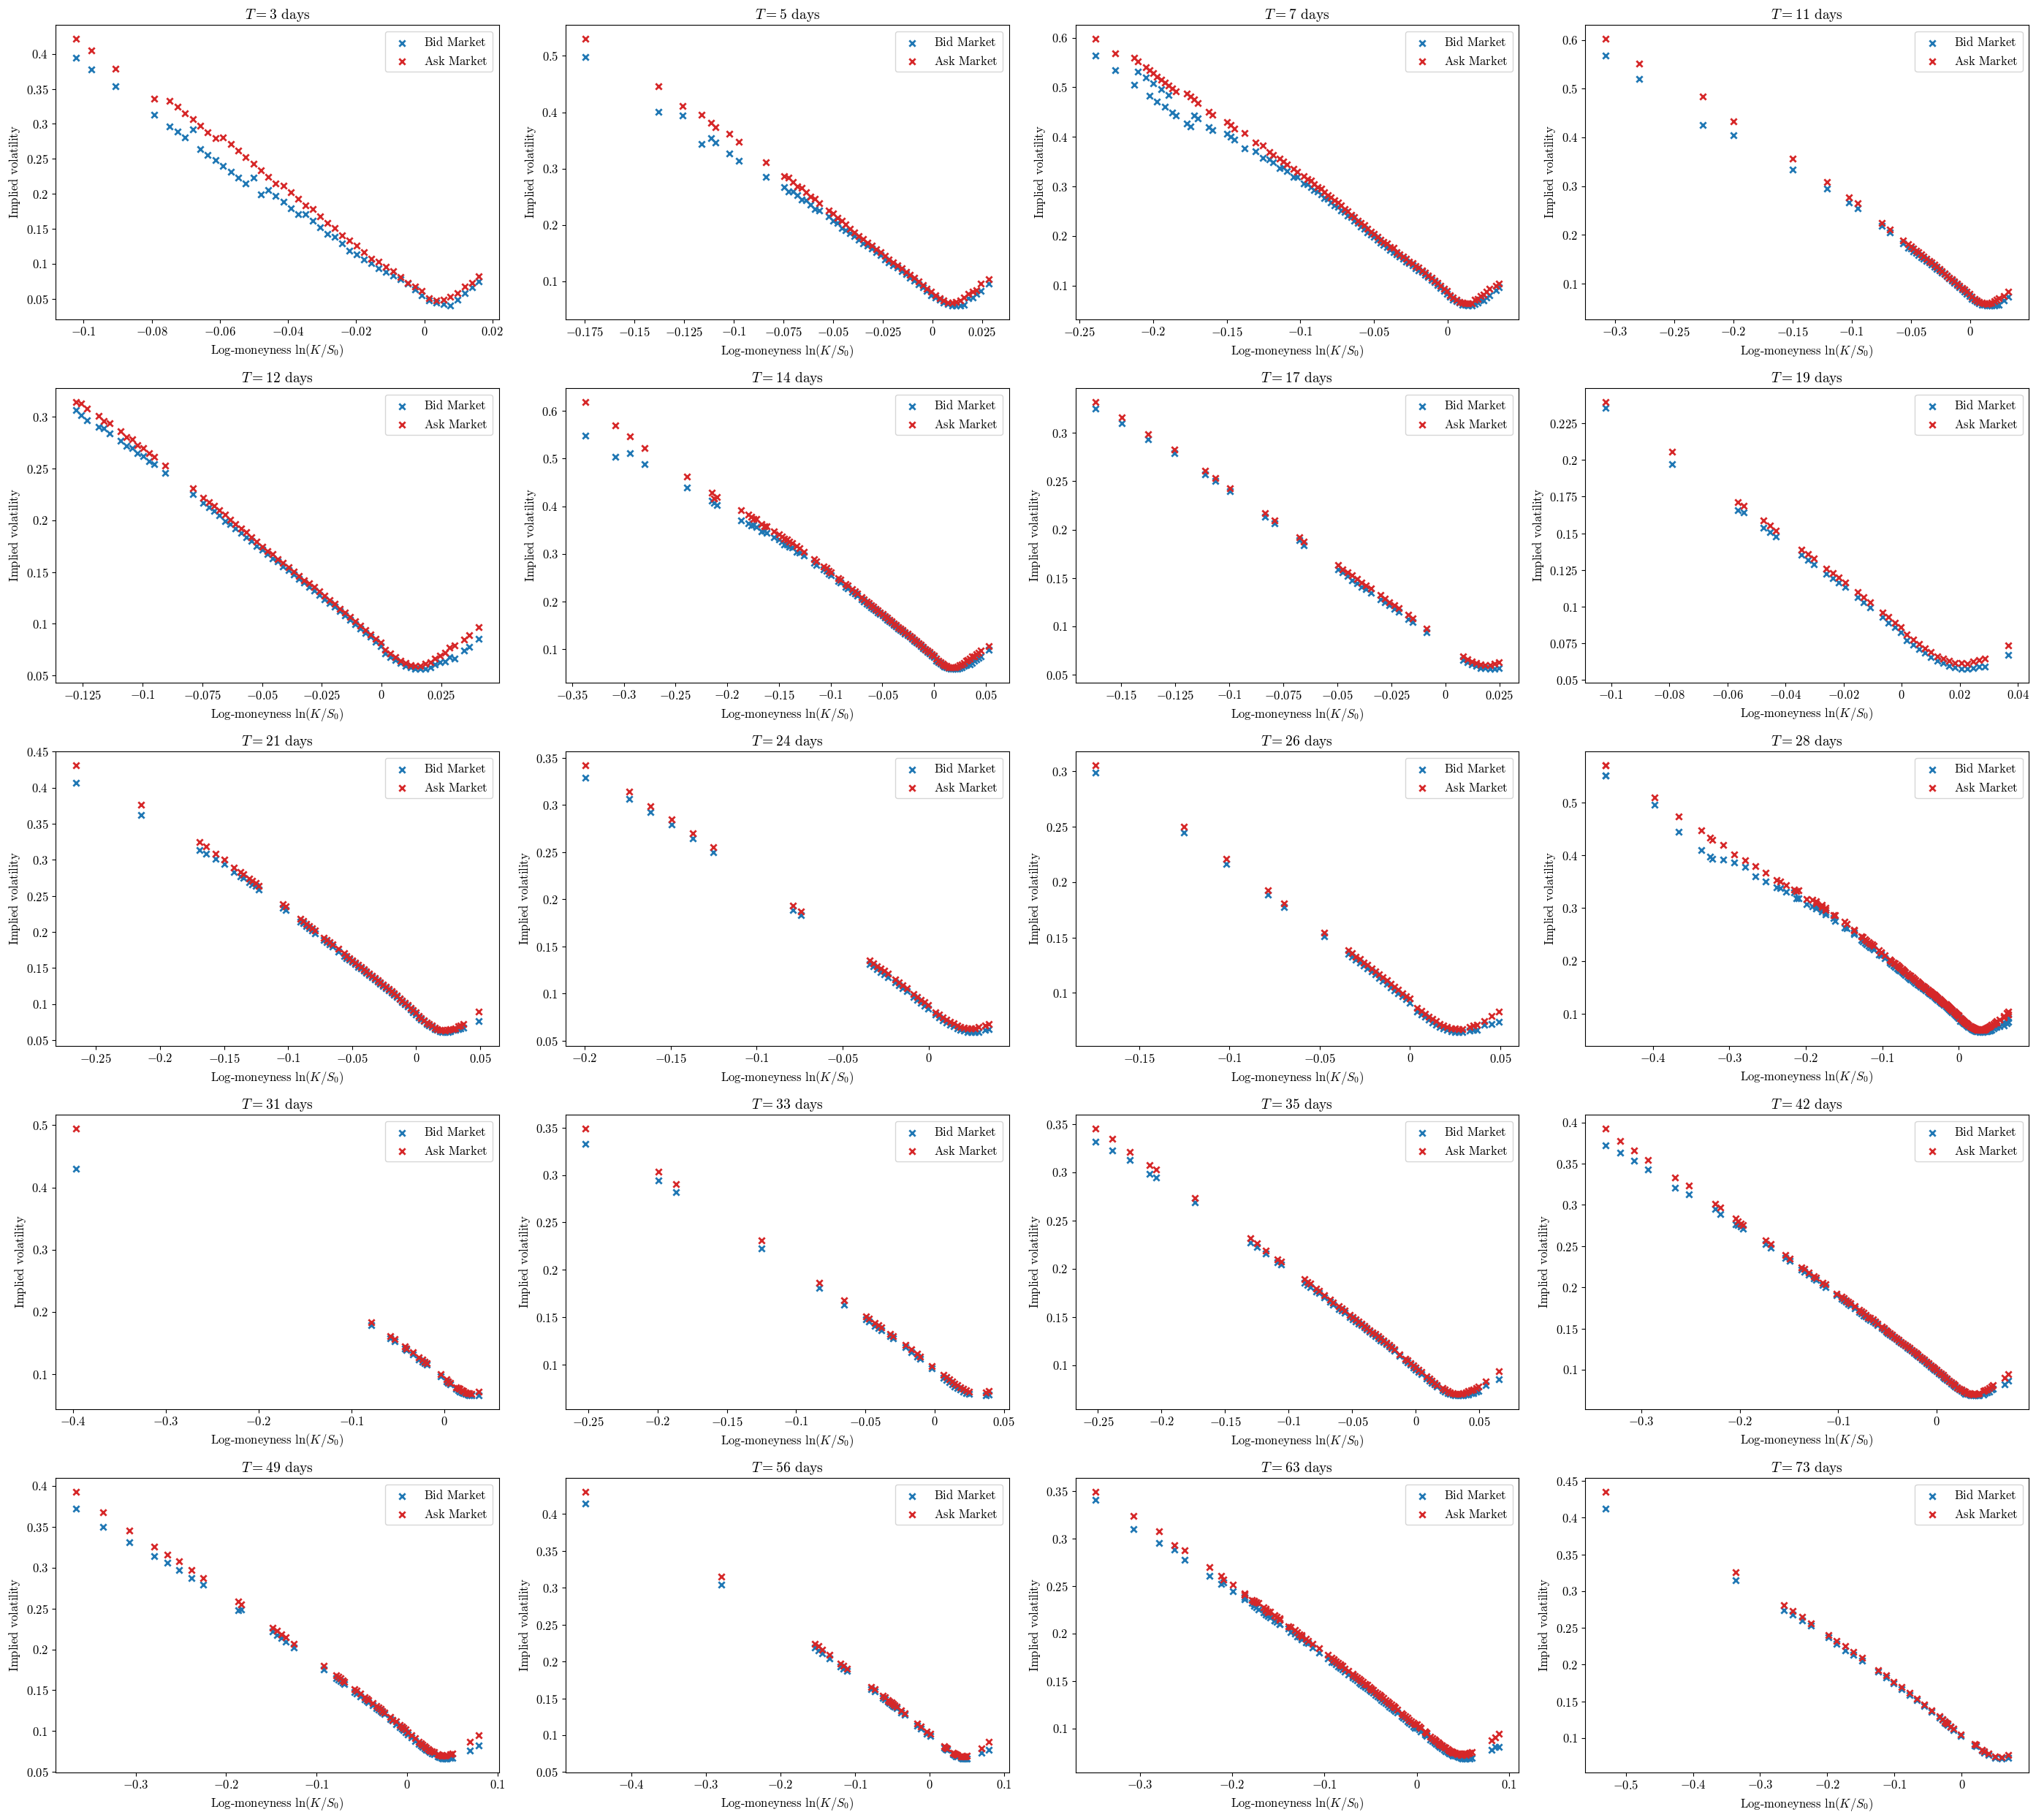

In [11]:
plot_IV_SPX(SPX)

In [12]:
expiration_dates, variance_swap_mid, variance_swap_bid, variance_swap_ask = variance_swap(SPX)

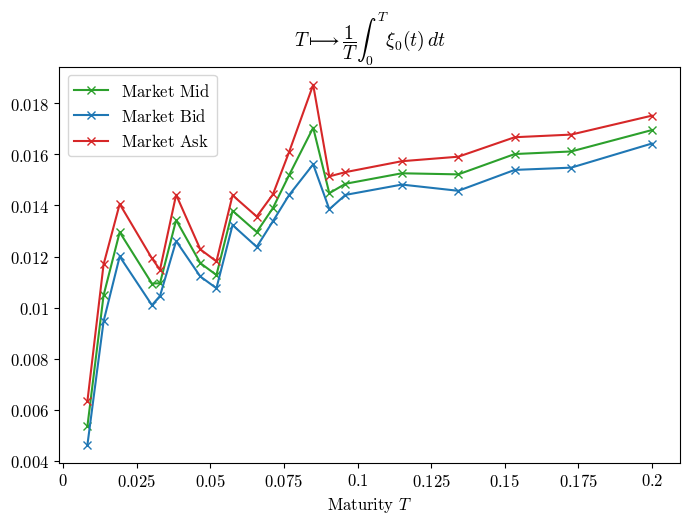

In [16]:
fig, ax = plt.subplots(figsize=(7,5.35))
ax.plot(expiration_dates, variance_swap_mid, "x-", color="tab:green", label=r"$\text{Market Mid}$")
ax.plot(expiration_dates, variance_swap_bid, "x-", color="tab:blue", label=r"$\text{Market Bid}$")
ax.plot(expiration_dates, variance_swap_ask, "x-", color="tab:red", label=r"$\text{Market Ask}$")
ax.set_title(r"$T\longmapsto \dfrac{1}{T}\int_0^T \xi_0(t)\, dt$", fontsize=14)
ax.set_xlabel(r"$\text{Maturity }T$", fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [18]:
w = variance_swap_mid * expiration_dates 

In [20]:
xi_curve, _, w_smooth = smooth_curve(expiration_dates, w, xi=True, eps=0.01)

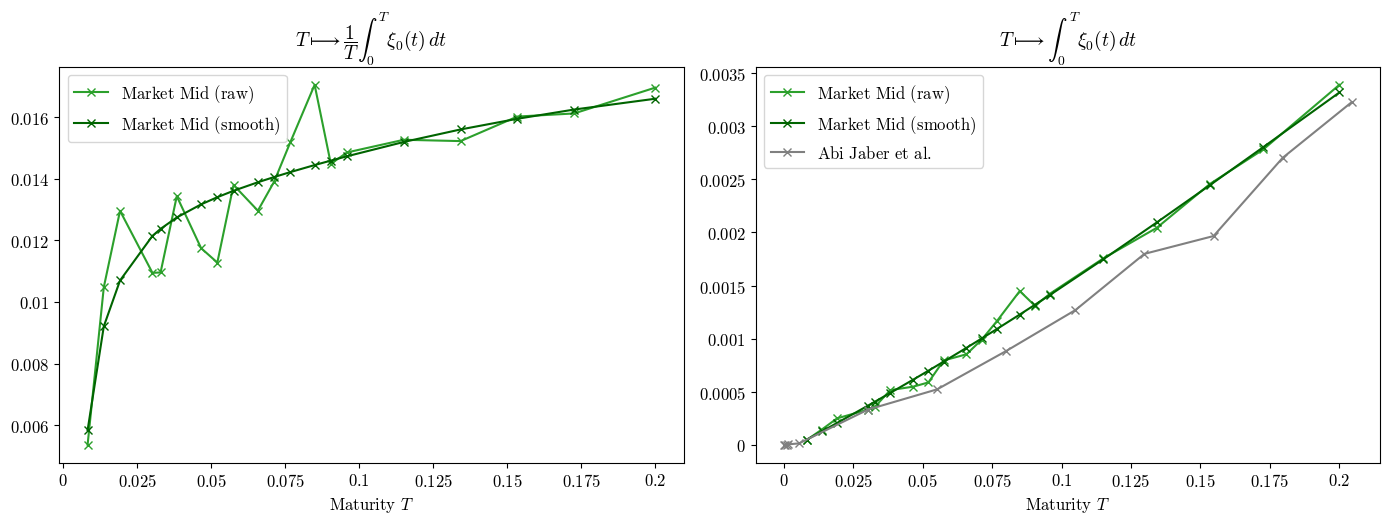

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(7*2,5.35))
ax[0].plot(expiration_dates, variance_swap_mid, "x-", color="tab:green", label=r"$\text{Market Mid (raw)}$")
ax[0].plot(expiration_dates, w_smooth/expiration_dates, "x-", color="darkgreen", label=r"$\text{Market Mid (smooth)}$")

ax[0].set_title(r"$T\longmapsto \dfrac{1}{T}\int_0^T \xi_0(t)\, dt$", fontsize=14)
ax[0].set_xlabel(r"$\text{Maturity }T$", fontsize=12)

ax[1].plot(expiration_dates, w, "x-", color="tab:green", label=r"$\text{Market Mid (raw)}$")
ax[1].plot(expiration_dates, w_smooth, "x-", color="darkgreen", label=r"$\text{Market Mid (smooth)}$") ## Market data from may 2017 
ax[1].plot(T_NODES[:13], INT_VAR_NODES[:13], "x-", color="gray", label=r"$\text{Abi Jaber et al.}$") ## Market data from oct 2017 

ax[1].set_title(r"$T\longmapsto \int_0^T \xi_0(t)\, dt$", fontsize=14)
ax[1].set_xlabel(r"$\text{Maturity }T$", fontsize=12)

for i in range(2):
    ax[i].tick_params(axis='both', labelsize=12)
    ax[i].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].legend(fontsize=12)
plt.tight_layout()
plt.show()

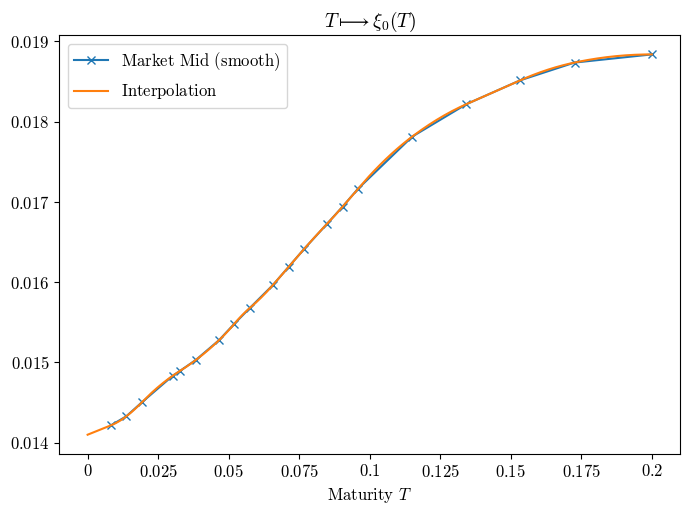

In [26]:
fig, ax = plt.subplots(figsize=(7, 5.25))

t_grid = np.linspace(0, 0.2, 300)
ax.plot(expiration_dates, xi_curve(expiration_dates), "x-", label=r"$\text{Market Mid (smooth)}$")
ax.plot(t_grid, xi_curve(t_grid), label=r"$\text{Interpolation}$")
ax.set_title(r"$T\longmapsto\xi_0(T)$", fontsize=14)
ax.set_xlabel(r"$\text{Maturity }T$", fontsize=12)

ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()